<h1>Crispnectar Juices User Application Walkthrough</h1>

To begin understanding how this tool functions, please read along with the various explanations and code blocks below. Do not worry if you do not understand everything, as total comprehension is not necessary to appreciate the value of what is occurring to make this tool possible. Just as well, if you have already read this before or simply wish to skip ahead to where you can interact directly with the machine learning model, please scroll all the way to the bottom.

Additionally, only the parts deemed necessary to explain the model at a high level were included here. If you wish to view the model in its entirety, please refer to the source code. 

<h2>Project Set Up</h2>

To make our model, visualize the data it utilizes, and illustrate its performance, we first need to download various open-source libraries specifically designed for these tasks. Leveraging these libraries will drastically decrease the amount of code that needs to be written while simultaneously increasing the quality of model creation and testing. 

In [10]:
import pandas as pd
from matplotlib import pyplot as plt  # for basic histogram
import seaborn as sns  # for univariate analysis
from scipy import stats
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

<h2>Data Setup</h2>

Now that we have the basic tools needed, we can begin creating our model. First, let's get our data uploaded and stored in a variable for later. Then, after checking the data for incomplete entries or inappropriate data types, we edit the data as needed to account for these issues. It is of the utmost importance that these irregularities are dealth with prior to any calculations so that accuracy can be ensured to the greatest extent possible. 

Below in the visualization, which shows the first five entries of the data set, you can see that we removed the "A_id" (Apple ID) column because it is unnecessary for our purposes. We can also see a small glimpse as to what separates a good apple from a bad one. 

In [11]:
apple_data = pd.read_csv('./apple_quality.csv')
apple_data = apple_data.drop("A_id", axis=1)  # removes the 'A_id' column, as it's not needed nor does it add value for our purposes
apple_data = apple_data.dropna(ignore_index=True)   # removes row that is filled with NaN values (was row 4000)
apple_data['Acidity'] = pd.to_numeric(apple_data['Acidity'], errors='coerce')  # 'Acidity' was of type 'object' for some reason — changes to float

apple_data.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good


<h2>Descriptive Statistics</h2>

We've seen a little bit of the data, but let's look at the data in general with some basic statistic analysis. Out of the 4000 apples in this data set, what might be the maximum size? The minimum acidity? We can see all of that and more below:

In [12]:
cols = apple_data.columns.to_list()[:-1]
apple_data[cols].describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736


<h2>Distribution of Quality</h2>

Out of the 4000 apples in our shipment that we'd like to classify, what is the distribution of "Quality" (i.e. the dependent variable)? How many good or bad apples do we have total of each? Let's find out:

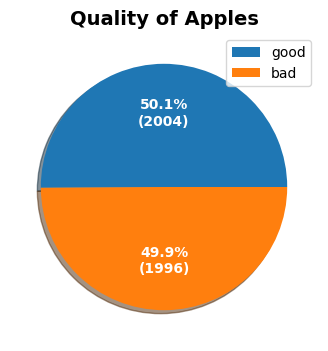

In [13]:
df_quality = apple_data['Quality'].value_counts().to_frame()
labels = df_quality.index.to_list()
values = df_quality.iloc[:, 0].to_list()


def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"


fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(x=values, labels=labels, autopct=autopct_fun(values), shadow=True,
       textprops={'color': 'white', 'fontsize': 10, 'fontweight': 'bold'})
ax.legend(labels)
ax.set_title("Quality of Apples", fontsize=14, fontweight="bold", color="black")
fig.show()

It seems that the distribution of quality is just about split right down the middle, with approximately 2000 apples each good or bad. This means that our machine learning model, at the barest of minimums possible, should aim for an initial prediction accuracy of at least 50% or greater.

<h2>Distribution of Variables</h2>

By performing univariate analysis, we can get a better glimpse as to how the independent variables like sweetness and juiciness are distributed. By viewing these graphs, and by performing further normality tests, we can assess to what extent our apples' factors have a normal distribution.

There appear to be a few outliers, but for the most part each independent variable is mostly normal.

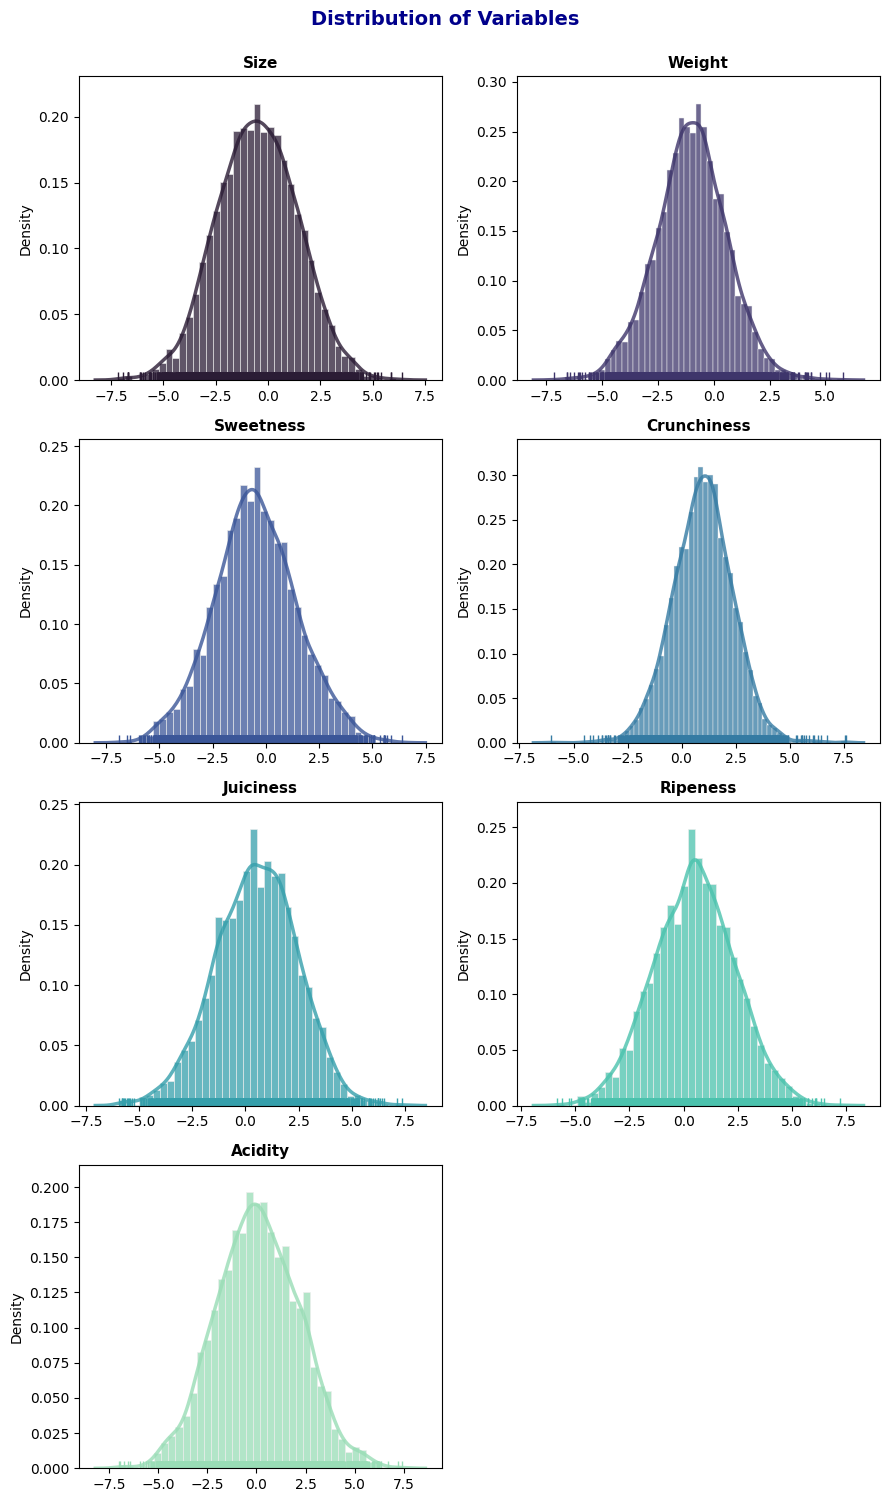

In [14]:
cols = apple_data.columns.to_list()[:-1]  # '[:-1]' ignores the last item in a list; so no "quality" metric will be shown
colors = sns.color_palette('mako', len(cols))

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 15))
plt.style.use("ggplot")
axs = axs.flat

for i, col in enumerate(cols):
    sns.kdeplot(apple_data, x=col, alpha=0.8, linewidth=2.5, color=colors[i], ax=axs[i])
    sns.histplot(apple_data, x=col, stat='density', color=colors[i], ax=axs[i])
    sns.rugplot(apple_data, x=col, color=colors[i], ax=axs[i])
    axs[i].set_xlabel("")
    axs[i].set_title(col, fontsize=11, fontweight="bold", color="black")

fig.suptitle("Distribution of Variables", fontsize=14, fontweight="bold", color="darkblue", y=0.998)
fig.delaxes(ax=axs[7])
fig.tight_layout()
fig.show()

<h2>Examining Correlation</h2>

There are a total of seven dimensions that we are considering as independent variables. So, it may be worthwhile to first test whether there is any strong relationship between any of these variables. We can do this by creating a correlation matrix like so:

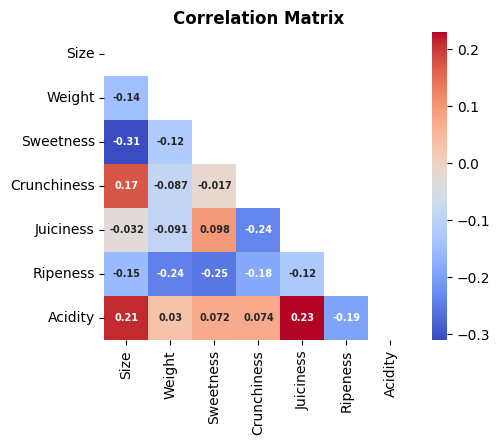

In [15]:
corr_matrix = apple_data[cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(5, 4))
plt.style.use('default')
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={'fontsize': 7, 'fontweight': 'bold'}, square=True,
            mask=mask)
plt.title("Correlation Matrix", fontsize=12, fontweight="bold")
plt.show()

Based on the results of the above correlation matrix, it appears that there is not much of a relationship between any of the variables. As such, we will likely need to consider all independent variables to get the most accurate results possible for our apple quality predictions. 

<h2>Model Creation & Training</h2>

Now that we've viewed some basics of the apple data, it's time to actually create some models! 

Due to the nature of the data being used, we suspected during our initial research that SVC (Support Vector Classification) would be a better fit than Logistic Regression. So, we'll be training two separate models, one of each, and compare how accurate they are against one another upon testing. 

In [16]:
label2id = {'bad': 0, 'good': 1}
apple_data['Quality'] = apple_data['Quality'].map(label2id)

X = apple_data.drop('Quality', axis=1)
y = apple_data['Quality']

SEED = 41

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.233, random_state=SEED)

SVC_model = SVC(probability=True, random_state=SEED)
log_model = linear_model.LogisticRegression(random_state=SEED, n_jobs=-1)

all_models = [SVC_model, log_model]

accuracy_train = {}
accuracy_test = {}

for model in tqdm(all_models):
    name = type(model).__name__
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    accuracy_train[name] = accuracy_score(y_train, y_pred_train)
    accuracy_test[name] = accuracy_score(y_test, y_pred_test)

  0%|          | 0/2 [00:00<?, ?it/s]

Now that the models are trained and tested, we can visualize their results:

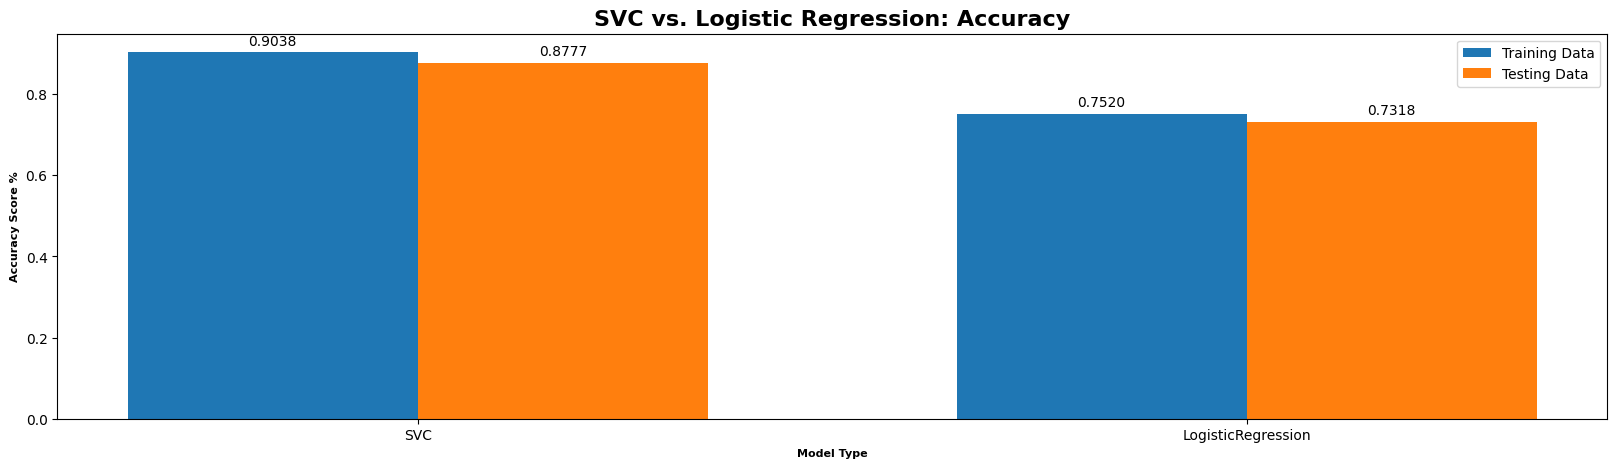

In [17]:
metric_train = pd.DataFrame.from_dict(accuracy_train, orient='index')
metric_train = metric_train.rename(columns={0: 'Train'})

metric_test = pd.DataFrame.from_dict(accuracy_test, orient='index')
metric_test = metric_test.rename(columns={0: 'Test'})

fig, ax = plt.subplots(figsize=(20, 5))

labels = metric_train.index.to_list()
values_train = metric_train.iloc[:, 0].to_list()
values_test = metric_test.iloc[:, 0].to_list()
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x=x - width / 2, height=values_train, width=width, label='Training Data')
rects2 = ax.bar(x=x + width / 2, height=values_test, width=width, label='Testing Data')

# This method will allow for auto labeling of bar chart when multiple models are displayed
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text=f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center",
                    va="bottom")


autolabel(rects1)
autolabel(rects2)

ax.set_title("SVC vs. Logistic Regression: Accuracy", fontsize=16, fontweight="bold", color="black")
ax.set_ylabel("Accuracy Score %", fontsize=8, fontweight="bold", color="black")
ax.set_xlabel("Model Type", fontsize=8, fontweight="bold", color="black")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.show()

<h2>Final Model for User Input</h2>

As suspected, SVC does indeed lead to greater accuracy than Logistic Regression, with SVC's accuracy performance on test data being almost 15% greater. 

We will now use the SVC model to make predictions on new, manually input data. In order to do that, let's choose SVC as our final model and then create some sliders that a user can manipulate to represent float numbers to then make a predictions:

In [18]:
best_model = SVC_model

#The sliders where the user can input values. Min and max are set by using the complete datasets' 
size_widget = widgets.FloatSlider(description='Size:',min=-8.0, max=8.0)
weight_widget = widgets.FloatSlider(description='Weight:', min=-8.0, max=8.0)
sweetness_widget = widgets.FloatSlider(description='Sweetness:', min=-8.0, max=8.0)
crunchiness_widget = widgets.FloatSlider(description='Crunchiness:', min=-8.0, max=8.0)
juiciness_widget = widgets.FloatSlider(description='Juiciness:', min=-8.0, max=8.0)
ripeness_widget = widgets.FloatSlider(description='Ripeness:', min=-8.0, max=8.0)
acidity_widget = widgets.FloatSlider(description='Acidity:', min=-8.0, max=8.0)

#Defines what happens when you click the button 
def predict_apple_quality(sz, wt, sw, cr, ju, ri, ac):
    prediction = best_model.predict([[
        sz, 
        wt, 
        sw, 
        cr,
        ju,
        ri,
        ac
    ]])
    
    if prediction[0] == 1:
        print('Looks like you have a good apple!')
    if prediction[0] == 0:
        print('Looks like you have a BAD apple!')

    return
    
print("Please adjust the sliders below as desired, then click the 'Predict Apple Quality' Button to predict the quality of the apple you've created.")
print("Your result will appear below the button.")

renamed_interact_manual = interact_manual.options(manual_name="Predict Apple Quality")
renamed_interact_manual(predict_apple_quality, sz=size_widget, wt=weight_widget, sw=sweetness_widget, cr=crunchiness_widget, ju=juiciness_widget, ri=ripeness_widget, ac=acidity_widget);

Please adjust the sliders below as desired, then click the 'Predict Apple Quality' Button to predict the quality of the apple you've created.
Your result will appear below the button.


interactive(children=(FloatSlider(value=0.0, description='Size:', max=8.0, min=-8.0), FloatSlider(value=0.0, d…